In [1]:
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
plt.style.use("./paper.mplstyle")
from scipy.optimize import curve_fit
power_law = lambda x, c, gamma: c*x**(-gamma) # gamma is power law exponent
exponential_law = lambda x, c, T: c*np.exp(-x/T) # T is time scale
gaussian = lambda x, mu, sigma: 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*((x-mu)/sigma)**2)
from gol import SporeLife, GameOfLife
from gol import ALIVE, SPORE, DEAD
from mean_field import MFSporeLife
from util import random_init_grid

# Mean Field Theory

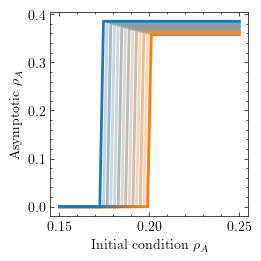

In [55]:
# Plot initial condition over asymptotic density
gen_init = lambda rho_a: (rho_a, 0., 1-rho_a)
rho_inits = np.array([(rho_a, 0., 1-rho_a) for rho_a in np.linspace(0.15, 0.25, 50)])

# Define the colormap and normalization
from matplotlib.colors import Normalize, LinearSegmentedColormap
colors = ['tab:orange', 'tab:blue']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
norm = Normalize(vmin=0, vmax=1)

fig, (axl, axr) = plt.subplots(ncols=2, figsize=(5, 2.5))
axl.set(xlabel=r"Initial condition $\rho_A$", ylabel=r"Asymptotic $\rho_A$")
for alpha in np.linspace(0, 1, 20):
    rho_asymp = [(MFSporeLife(init, alpha=alpha).step_until(100)[0])[-1] for init in rho_inits]
    if alpha == 0 or alpha == 1:
        axl.plot(rho_inits[:,0], rho_asymp, c=cmap(norm(alpha)), label=r"$\alpha = %.1f$" % alpha)
    else:
        axl.plot(rho_inits[:,0], rho_asymp, c=cmap(norm(alpha)), alpha=0.3)

axr.plot
# ax.legend()
# fig.savefig("img/mean-field.pdf")
# fig.savefig("img/mean-field.svg", format="svg", dpi=500)

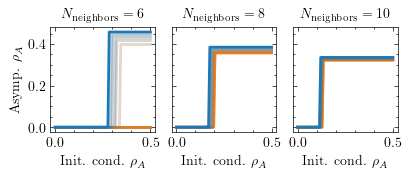

In [30]:
# lss = ["--", "-", "-."]
gen_init = lambda rho_a: (rho_a, 0., 1-rho_a)
rho_inits = np.array([(rho_a, 0., 1-rho_a) for rho_a in np.linspace(0.0, 0.5, 75)])
# for i, n_neighbors in enumerate(range(6, 11, 2)):
#     data_al0 = [(MFSporeLife(init, alpha=0, n_neighbors=n_neighbors).step_until(100)[0])[-1] for init in rho_inits]
#     data_al1 = [(MFSporeLife(init, alpha=1, n_neighbors=n_neighbors).step_until(100)[0])[-1] for init in rho_inits]
#     plt.plot(rho_inits[:,0], data_al0, ls=lss[i], c="tab:orange", label=f"{n_neighbors}")
#     plt.plot(rho_inits[:,0], data_al1, ls=lss[i], c="tab:blue")
# plt.legend()

# Define the colormap and normalization
from matplotlib.colors import Normalize, LinearSegmentedColormap
colors = ['tab:orange', 'tab:blue']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
norm = Normalize(vmin=0, vmax=1)

fig, axs = plt.subplots(ncols=3, nrows=1, sharey=True, figsize=(4, 1.8))
axs[0].set(box_aspect=1, xlabel=r"Init. cond. $\rho_A$", ylabel=r"Asymp. $\rho_A$")
axs[1].set(box_aspect=1, xlabel=r"Init. cond. $\rho_A$")
axs[2].set(box_aspect=1, xlabel=r"Init. cond. $\rho_A$")
for i, n_neigh in enumerate(range(6, 11, 2)):
    axs[i].set(title=fr"$N_\mathrm{{neighbors}} = {n_neigh}$")
    for alpha in np.linspace(0, 1, 10):
        rho_asymp = [(MFSporeLife(init, alpha=alpha, n_neighbors=n_neigh).step_until(100)[0])[-1] for init in rho_inits]
        if alpha == 0 or alpha == 1:
            axs[i].plot(rho_inits[:,0], rho_asymp, c=cmap(norm(alpha)))
        else:
            axs[i].plot(rho_inits[:,0], rho_asymp, c=cmap(norm(alpha)), alpha=0.3)
fig.savefig("img/mean-field-neighbors.pdf")
fig.savefig("img/mean-field-neighbors.svg", format="svg", dpi=500)

# Supplementary Material -- Quick

In [21]:
# DEAD cell with 4 neighbors might be born with probability
# Plot: x axis: alpha values, y axis asymptotic alive density averaged over runs.
runs = 20
grid_size = 100
overcrowd_birth_p = 0.3
t_max = 3000
alphas = np.linspace(0, 1, 20)

def average_timeseries(data: np.ndarray, t_avg: int):
    """data is (runs) x (t_max)"""
    data_cut = data[:, -t_avg:]
    return np.mean(data_cut.flatten())

def gen_data_array(grid_size, runs, alpha, t_max, overcrowd_birth_p):
    data = np.zeros((runs, t_max+1))
    for r in tqdm(range(runs), leave=False, desc=f"{alpha:.2f}"):
        sl = SporeLife(random_init_grid(grid_size), alpha=alpha)
        data[r] = sl.alive_count_time_series(t_max, overcrowd_birth_p=overcrowd_birth_p)
    return data

rhos = []
for alpha in alphas:
    data = gen_data_array(grid_size, runs, alpha, t_max, overcrowd_birth_p)
    rhos.append(average_timeseries(data, 750))
rhos = np.array(rhos)
rhos /= grid_size**2

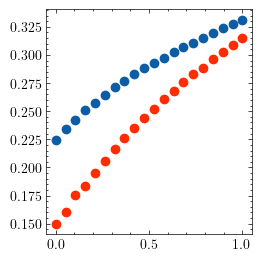

In [24]:
alphas, rho1 = np.loadtxt("data/spore-life/suppl-mat-quick-and-dirty/densities_over_alpha_for_50pc_overcrowd_birth_p.dat")
alphas, rho2 = np.savetxt("data/spore-life/suppl-mat-quick-and-dirty/densities_over_alpha_for_30pc_overcrowd_birth_p.dat", (alphas, rhos))
plt.scatter(alphas, np.array(rho1))
plt.scatter(alphas, np.array(rhos))

0.29295975415602205


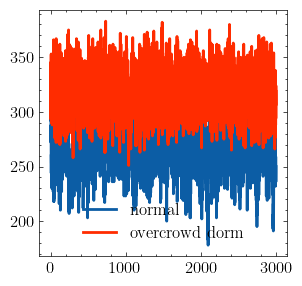

In [32]:
t_max = 3000
alpha = 1
ig = random_init_grid(30)
sl = SporeLife(ig, alpha)
alive_data_oc = sl.alive_count_time_series(t_max, overcrowd_dormancy=True)
# while sl.t < t_max:
#     alive_data_oc[sl.t] = sl.alive_count
#     sl.step(overcrowd_dormancy=True)

sl = SporeLife(ig, alpha)
alive_data = sl.alive_count_time_series(t_max)
# alive_data = np.zeros(t_max)
# while sl.t < t_max:
#     alive_data[sl.t] = sl.alive_count
#     sl.step(overcrowd_dormancy=False)
fig, ax = plt.subplots()
ax.plot(alive_data, label="normal")
ax.plot(alive_data_oc, label="overcrowd dorm")
ax.legend()
print(np.mean(alive_data)/30**2)

In [3]:
def alive_density_averaged(alpha, grid_size, t_max, t_trans, runs, overcrowd_dormancy):
    data = np.zeros(t_max+1)
    for _ in range(runs):
        init_grid = random_init_grid(grid_size)
        sl = SporeLife(init_grid, alpha=alpha)
        data += sl.alive_count_time_series(t_max, overcrowd_dormancy=overcrowd_dormancy)
    data /= runs
    data /= (grid_size**2) # density
    return np.mean(data[t_trans:])

In [4]:
alphas = np.linspace(0, 1, 15)
avg_densities_oc = []
for alpha in alphas:
    print(alpha, end=" ")
    avg_densities_oc.append(alive_density_averaged(alpha, 30, 10000, 300, 15, True))
np.savetxt("./data/spore-life/suppl-mat-quick-and-dirty/avg_alive_density_overcrowd_dormancy_30x30.dat", (alphas, avg_densities_oc), header="Data: alphas, average alive densities, grid_size 30, t_max=10000, t_trans = 300, 15 runs")

0.0 0.07142857142857142 0.14285714285714285 0.21428571428571427 0.2857142857142857 0.3571428571428571 0.42857142857142855 0.5 0.5714285714285714 0.6428571428571428 0.7142857142857142 0.7857142857142857 0.8571428571428571 0.9285714285714285 1.0 

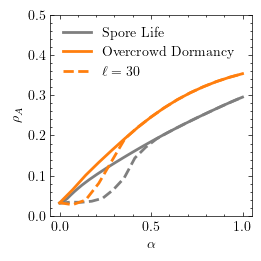

In [4]:
fig, ax = plt.subplots()
ax.set(xlabel=r"$\alpha$", ylabel=r"$\rho_{A}$", box_aspect=1, ylim=(0.0, 0.5))
# normal SporeLife
t_trans = 300
base_path = "data/spore-life/time-series"
alphas = np.loadtxt(os.path.join(base_path, "grid-size-300/alpha-range.dat"))
# density_30 = np.array([np.mean(np.loadtxt(os.path.join(base_path, "grid-size-30/alive", "alpha-%.3f.dat"%alpha))[:, t_trans:])/(30**2) for alpha in alphas])
# Plot splines to smooth out data
from scipy.interpolate import make_interp_spline, BSpline
spline_alphas = np.linspace(0, 1, 18)
density_30_smoothed = (make_interp_spline(alphas, density_30, k=3))(spline_alphas)
ax.plot(spline_alphas, density_30_smoothed, c="tab:gray", linestyle="--")
alphas = np.loadtxt(os.path.join(base_path, "grid-size-30/alpha-range.dat"))
# density_300 = np.array([np.mean(np.loadtxt(os.path.join(base_path, "grid-size-300/alive", "alpha-%.3f.dat"%alpha))[:, t_trans:])/(300**2) for alpha in alphas])
ax.plot(alphas, density_300, c="tab:gray", label="Spore Life")

# SporeLife with overcrowding dormancy
ax.plot(*np.loadtxt("data/spore-life/suppl-mat-quick-and-dirty/avg_alive_density_overcrowd_dormancy.dat"), c="tab:orange", label=r"Overcrowd Dormancy")
ax.plot(*np.loadtxt("data/spore-life/suppl-mat-quick-and-dirty/avg_alive_density_overcrowd_dormancy_30x30.dat"), c="tab:orange", linestyle="--", label=r"$\ell = 30$")
ax.legend()
fig.savefig("img/sm-overcrowd-dormancy.pdf")

# Lifetime Distribution of Spores

1 [0.0257277  4.56497275]
0.7 [0.06482728 2.11171723]
0.3 [0.22792432 0.74028053]


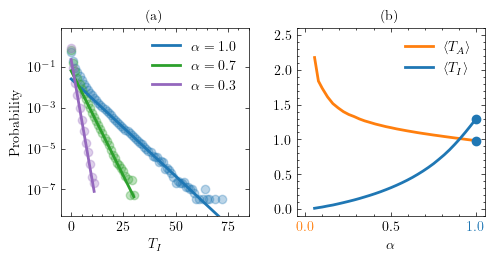

In [145]:
from collections import Counter
from lifetime_distribution import lifetime_distribution

base_path = "data/spore-life/avg-lifetimes/"

N = 300; t_max = 10_000; t_trans = 200

def avg_lifetime(state, N, t_max, t_trans, alpha):
    sl = SporeLife(random_init_grid(N), alpha=alpha)
    distr: Counter = lifetime_distribution(state, sl, t_max, t_trans)
    vals, counts = np.fromiter(distr.keys(), np.intc), np.fromiter(distr.values(), np.intc)
    return np.sum(vals*counts)/np.sum(counts)

fig, (axl, axr) = plt.subplots(figsize=(5, 2.5), ncols=2)
axl.set(
    xlabel=r"$T_I$",
    ylabel=r"Probability",
    yscale="log",
    xlim=(-5, 85),
    ylim=(10**(-8.3), 8),
    title="(a)",
    box_aspect=1
)
for alpha, c in zip([1, .7, .3], ["tab:blue", "tab:green", "tab:purple"]):
    sl = SporeLife(random_init_grid(N, seed=100), alpha=alpha)
    distr: Counter = lifetime_distribution(SPORE, sl, t_max, t_trans)
    vals, counts = np.fromiter(distr.keys(), np.intc), np.fromiter(distr.values(), np.intc)
    vals_sort_permut = vals.argsort()
    vals, probs = vals[vals_sort_permut], counts[vals_sort_permut]/np.sum(counts)
    popt, _ = curve_fit(exponential_law, vals[int(len(vals)/3):], probs[int(len(vals)/3):], p0=(1, 1))
    print(alpha, popt)
    axl.scatter(vals, probs, alpha=0.3, c=c)
    axl.plot(vals, exponential_law(vals, *popt), c=c,
            # label=r"$\alpha = %.1f$: $%.2f\cdot\mathrm{e}^{-t/%.2f}$"%(alpha, popt[0], popt[1])
            label=r"$\alpha = %.1f$"%(alpha)
            )
axl.legend(loc="upper right")

alphas = np.loadtxt(os.path.join(base_path, "alpha-range.dat"))
axr.set(xlabel=r"$\alpha$", ylim=(-.1, 2.6), xlim=(-0.05, 1.05),
        title="(b)", box_aspect=1)
axr.set_xticks([0.0, 0.5, 1.0])
xtick_labels = axr.get_xticklabels()
xtick_labels[0].set_color("tab:orange")
xtick_labels[2].set_color("tab:blue")
alive_avg_lifetimes = np.loadtxt(os.path.join(base_path, "alive-lifetimes.dat"))
spore_avg_lifetimes = np.loadtxt(os.path.join(base_path, "spore-lifetimes.dat"))
axr.plot(alphas, alive_avg_lifetimes,
        c="tab:orange", label=r"$\langle T_A\rangle$")
axr.plot(alphas, spore_avg_lifetimes,
        c="tab:blue", label=r"$\langle T_I\rangle$")
axr.scatter(x=1, y=alive_avg_lifetimes[-1], c="tab:blue", zorder=10)
axr.scatter(x=1, y=spore_avg_lifetimes[-1], c="tab:blue", zorder=10)
# axr.plot(alphas, alphas/(1-alphas))
axr.legend()
fig.savefig("img/spore-lifetime-distr.pdf")
fig.savefig("img/spore-lifetime-distr.svg", format="svg")

## Lifetimes of ALIVE cells -- Supplement

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


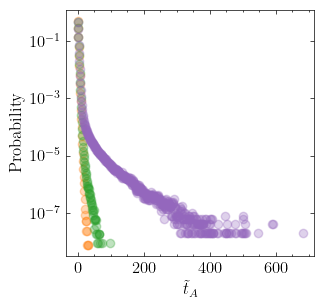

In [145]:
from collections import Counter
from lifetime_distribution import lifetime_distribution
N = 300; t_max = 10_000; t_trans = 200

fig, ax = plt.subplots()
ax.set(
    xlabel=r"$\tilde{t}_A$",
    ylabel=r"Probability",
    yscale="log",
    # xlim=(-5, 85),
    # ylim=(10**(-7.1), 10)
)
for alpha, c in zip([1, .8, .3], ["tab:orange", "tab:green", "tab:purple"]):
    sl = SporeLife(random_init_grid(N, seed=100), alpha=alpha)
    distr: Counter = lifetime_distribution(ALIVE, sl, t_max, t_trans)
    vals, counts = np.fromiter(distr.keys(), np.intc), np.fromiter(distr.values(), np.intc)
    vals_sort_permut = vals.argsort()
    vals, probs = vals[vals_sort_permut], counts[vals_sort_permut]/np.sum(counts)
    # popt, _ = curve_fit(exponential_law, vals[int(len(vals)/2):], probs[int(len(vals)/2):], p0=(10**(-4), 4))
    ax.scatter(vals, probs, alpha=0.3, c=c)
    # ax.plot(vals, exponential_law(vals, *popt), c=c,
    #         label=r"$\alpha = %.1f$: $%.2f\cdot\mathrm{e}^{-t/%.2f}$"%(alpha, popt[0], popt[1]))
ax.legend(loc="upper right")

# Distribution of Number of ALIVE cells, $N_A$ -- Supplement

Distribution of the number of ALIVE cells, averaged over time.

In [3]:
def generate_N_A_distr(alpha, t_trans, grid_size, normalize_counts=True, **hist_kwargs):
    base_path = f"data/spore-life/time-series/grid-size-{grid_size}/alive"
    alive_cell_data = np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[:, t_trans:]
    if normalize_counts:
        alive_cell_data /= grid_size**2
    # Establish defaults
    if "density" not in hist_kwargs:
        hist_kwargs["density"] = True
    if "bins" not in hist_kwargs:
        hist_kwargs["bins"] = 40
    probs, bin_edges = np.histogram(alive_cell_data, **hist_kwargs)
    return probs, bin_edges[:-1]

30x30: α = 0.3, (μ, σ) = [0.13428334 0.03998083]
30x30: α = 0.7, (μ, σ) = [0.23336811 0.03157472]
30x30: α = 1.0, (μ, σ) = [0.29258867 0.02426165]
300x300: α = 0.3, (μ, σ) = [0.13270278 0.00439037]
300x300: α = 0.7, (μ, σ) = [0.23548169 0.00318424]
300x300: α = 1.0, (μ, σ) = [0.29501114 0.00246077]


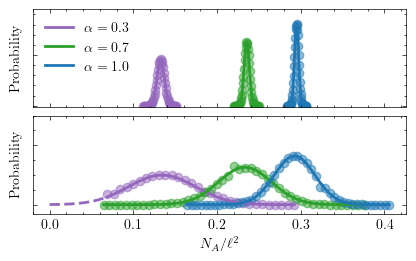

In [37]:
# fig, ax = plt.subplots(figsize=(3.2*1.618, 3.2))
fig, (axt, axb) = plt.subplots(figsize=(2.5*1.618, 2.5), nrows=2, sharex=True)
# fig.subplots_adjust(hspace=0.05)
axb.set(
    xlabel=r"$N_A/\ell^2$", ylabel=r"Probability",
    ylim=(-3, 30)
)
axb.yaxis.set_tick_params(labelleft=False)
axt.set(
    ylabel=r"Probability",
    ylim=(-3, 190)
)
axt.yaxis.set_tick_params(labelleft=False)
t_trans = 300
# #######
# 30 x 30
# #######
# alpha = 0.3
data_range = (0.069, 0.3)
p, b = generate_N_A_distr(0.306, t_trans, 30, range=data_range, bins=30)
axb.scatter(b, p, alpha=.5, c="tab:purple")
popt, _ = curve_fit(gaussian, b, p, p0=(0.135, 0.04))
# axb.plot(b, 1.02*gaussian(b, 0.135, 0.04))
axb.plot(b, gaussian(b, *popt), c="tab:purple", label=r"$\alpha = 0.3$")
# dotted in region of extinction
axb.plot(np.linspace(0, data_range[0], 20),
        gaussian(np.linspace(0, data_range[0], 20), *popt),
        c="tab:purple", linestyle="--")
print(f"30x30: α = 0.3, (μ, σ) = {popt}")
# alpha = 0.7
p, b = generate_N_A_distr(0.714, t_trans, 30, bins=47)
axb.scatter(b, p, alpha=.5, c="tab:green")
popt, _ = curve_fit(gaussian, b, p, p0=(0.235, 0.0325))
# axb.plot(b, 1*gaussian(b, 0.235, 0.0325))
axb.plot(b, gaussian(b, *popt), c="tab:green", label=r"$\alpha = 0.7$")
print(f"30x30: α = 0.7, (μ, σ) = {popt}")
# alpha = 1.0
p, b = generate_N_A_distr(1.0, t_trans, 30, bins=45)
axb.scatter(b, p, alpha=.5, c="tab:blue")
popt, _ = curve_fit(gaussian, b, p, p0=(0.293, 0.024))
# ax.plot(b, 1*gaussian(b, 0.293, 0.024))
axb.plot(b, gaussian(b, *popt), c="tab:blue", label=r"$\alpha = 1.0$")
print(f"30x30: α = 1.0, (μ, σ) = {popt}")

# axb.legend()

# #########
# 300 x 300
# #########
# alpha = 0.3
p, b = generate_N_A_distr(0.306, t_trans, 300, bins=48)
axt.scatter(b, p, alpha=.5, c="tab:purple")
popt, _ = curve_fit(gaussian, b, p, p0=(0.135, 0.04/10))
axt.plot(b, gaussian(b, *popt), c="tab:purple", label=r"$\alpha = 0.3$")
print(f"300x300: α = 0.3, (μ, σ) = {popt}")
# alpha = 0.7
p, b = generate_N_A_distr(0.714, t_trans, 300, bins=45)
axt.scatter(b, p, alpha=.5, c="tab:green")
popt, _ = curve_fit(gaussian, b, p, p0=(0.235, 0.0325/10))
axt.plot(b, gaussian(b, *popt), c="tab:green", label=r"$\alpha = 0.7$")
print(f"300x300: α = 0.7, (μ, σ) = {popt}")
# alpha = 1.0
p, b = generate_N_A_distr(1.0, t_trans, 300, bins=48)
axt.scatter(b, p, alpha=.5, c="tab:blue")
popt, _ = curve_fit(gaussian, b, p, p0=(0.293, 0.024/10))
axt.plot(b, gaussian(b, *popt), c="tab:blue", label=r"$\alpha = 1.0$")
print(f"300x300: α = 1.0, (μ, σ) = {popt}")

axt.legend(loc="upper left")

# fig.savefig("img/sm-alive-cell-distr.pdf")
# fig.savefig("img/sm-alive-cell-distr.svg")

# Extinction Times

In [129]:
def load_extinction_time_data(alpha, cleaned=True, subdir="spore-life"):
    base_path = f"./data/{subdir}/extinction-time/"
    fname = f"alpha-p{str(alpha)[2:]}.dat"
    data = np.loadtxt(os.path.join(base_path, fname))
    if cleaned:
        return data[data>0]
    return data

def gen_normalized_histogram(data: np.array, bin_min: float, bin_max: float,
                             bin_number: int) -> tuple[np.array, np.array]:
    """
    Generate a normalized histogram from data. Returns tuple with lower
    bin bounds (suitable for bar plot with kw align: "edge") and
    respective probabilities.
    """
    bins = np.arange(bin_min, bin_max, bin_max / bin_number)
    counts, bin_edges = np.histogram(data, bins=bins)
    probs = counts / len(data)
    return bin_edges[:-1], probs

def gen_adap_bin_histrogram(data: np.array,
                            data_per_bin: int,
                            strip_data: bool = True) -> tuple[np.array, np.array]:
    """
    Generate a normalized histogram from data with adaptive binning. Each bin
    holds data_per_bin data points. Therefore, bins are smaller in regions with
    a lot of data and larger in regions with scarce data. Returns tuple with
    center positions of bins (suitable for bar plot with kw align: "center") and
    respective probabilities, given by data_per_bin / bin_widths.
    If strip_data is True, the data is stripped (from the end of the sorted
    data array) to ensure that data fits into bins with data_per_bin data points.
    Note: If strip_data is False, the user has to ensure that the length of data
    fits with data_per_bin.
    """
    sorted_data = np.sort(data)
    bin_number = int(len(sorted_data) / data_per_bin)
    if strip_data:
        strip_idx = bin_number * data_per_bin
        sorted_data = sorted_data[:strip_idx]
    assert len(sorted_data) % data_per_bin == 0
    binned_data = np.reshape(sorted_data, (bin_number, data_per_bin))
    # Positions of bins on x-axis
    means = np.mean(binned_data, axis=1)
    bin_widths = binned_data[:, -1] - binned_data[:, 0]
    # Heights of the bars in bar chart
    probs = 1 / bin_widths
    return means, probs


[0.01202777 0.92448615]
[0.00382513 0.94657011]
[0.00168972 0.94501002]


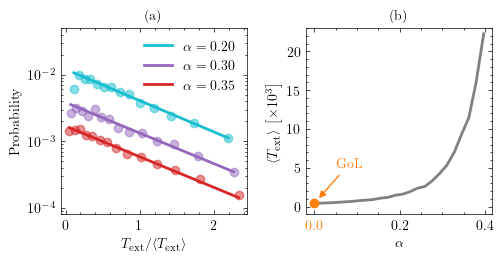

In [147]:
fig, (axl, axr) = plt.subplots(1, 2, figsize=(5, 2.5))
### LEFT ###
axl.set(xlabel=r"$T_\mathrm{ext} / \langle T_\mathrm{ext} \rangle$",
        title="(a)",
        ylabel="Probability",
        ylim=(0.8*10**(-4), 5*10**(-2)),
        yscale="log",
        box_aspect=1
        )
alphas_l = [0.2, 0.3, 0.35]
color_cycle = ["tab:cyan", "tab:purple", "tab:red"]
legend_handles = []
for alpha, c in zip(alphas_l, color_cycle):
    data = load_extinction_time_data(alpha)
    avg_extinction_time = np.mean(data)
    bin_centers, probs = gen_adap_bin_histrogram(data, 200)
    axl.scatter(bin_centers/avg_extinction_time, probs,
                color=c, alpha=.5,
                # label=r"$\alpha = %.2f$"%alpha,
                )
    # Fit
    popt, _ = curve_fit(exponential_law,
                        (bin_centers/avg_extinction_time)[3:], probs[3:])
    print(popt)
    axl.plot(bin_centers/avg_extinction_time,
             exponential_law(bin_centers/avg_extinction_time, *popt), color=c,
             label=r"$\alpha = %.2f$"%alpha
             # label=r"$\alpha = %.2f$: $%.4f\cdot\mathrm{e}^{-\bar{T}_\mathrm{ext}/%.2f}$"%(alpha, popt[0], popt[1])
        )
#     label_text = r"$\alpha = %.2f$: $%.3f\cdot\exp(x/%.1f)$"%(alpha, popt[0], popt[1])
#     legend_handles.append(mpl.lines.Line2D([],[], c=c, marker="o", label=label_text))
# Legend
# axl.legend(handlelength=1, loc=(0.03, 0.65))
axl.legend()
### RIGHT ###
axr.set(xlabel=r"$\alpha$",
        ylabel=r"$\langle T_\mathrm{ext} \rangle$ $\left[\times 10^3\right]$",
        title="(b)",
        ylim=(-1, 23),
        box_aspect=1,
        # yscale="log"
)
alphas = np.loadtxt("./data/spore-life/extinction-time/alpha-range.dat")
# Data above alpha = 0.4 numerically biased. Extinction times too long.
alphas = alphas[alphas<0.4]
extinction_times = np.array([np.mean(load_extinction_time_data(alpha)) for alpha in alphas])/1000
# axr.plot(-1/np.log(alphas[1:]), extinction_times[1:], color="gray")
axr.plot(alphas, extinction_times, color="gray")
# Draw marker for Game of Life
axr.annotate("GoL", (0, extinction_times[0]), xytext=(0.05, 5),
            arrowprops={"arrowstyle":"-|>", "relpos":(0.5, 0.5),
                        "color":"tab:orange", "shrinkB":5},
            c="tab:orange")
axr.scatter(x=0, y=extinction_times[0], c="tab:orange", zorder=10)
# Mark alphas from axl
# axr.set_xticks([0.0, 0.2, 0.3, 0.35, 0.4], labels=["0.0", "0.2", "0.3", "0.35", "0.4"])
# xtick_labels = axr.get_xticklabels()
# xtick_labels[0].set_color("tab:orange")
# xtick_labels[1].set_color(color_cycle[0])
# xtick_labels[2].set_color(color_cycle[1])
# xtick_labels[3].set_color(color_cycle[2])
axr.set_xticks([0.0, 0.2, 0.4], labels=["0.0", "0.2", "0.4"])
xtick_labels = axr.get_xticklabels()
xtick_labels[0].set_color("tab:orange")


# axr.scatter(x=0.2, y=np.mean(load_extinction_time_data(0.2))/1000, c="tab:cyan", zorder=10, alpha=0.5)
# axr.vlines(0.2, -1, np.mean(load_extinction_time_data(0.2))/1000, colors="tab:cyan", linestyles=":")
# axr.scatter(x=0.3, y=np.mean(load_extinction_time_data(0.3))/1000+0.4, c="tab:purple", zorder=10, alpha=0.5)
# axr.vlines(0.3, -1, np.mean(load_extinction_time_data(0.3))/1000, colors="tab:purple", linestyles=":")
# axr.scatter(x=0.35, y=np.mean(load_extinction_time_data(0.35))/1000+0.7, c="tab:red", zorder=10, alpha=0.5)
# axr.vlines(0.35, -1, np.mean(load_extinction_time_data(0.35))/1000, colors="tab:red", linestyles=":")

fig.savefig("img/extinction-times.pdf")
fig.savefig("img/extinction-times.svg", format="svg")

# Time Series

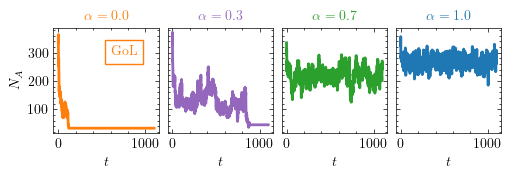

In [111]:
base_path = "data/spore-life/time-series/grid-size-30/"

fig, axs = plt.subplots(ncols=4, nrows=1, sharey=True, figsize=(5, 1.8))
axs[0].set(box_aspect=1, xlabel=r"$t$", ylabel=r"$N_A$")
axs[1].set(box_aspect=1, xlabel=r"$t$")
axs[2].set(box_aspect=1, xlabel=r"$t$")
axs[3].set(box_aspect=1, xlabel=r"$t$") 

alphas = [0, 0.306, 0.714, 1]
colors = ["tab:orange", "tab:purple", "tab:green", "tab:blue"]
t_max = 1100
for ax, alpha, c in zip(axs.flatten(), alphas, colors):
    ax.set_title(r"$\alpha=%.1f$"%alpha, c=c)
    time_series = np.loadtxt(os.path.join(base_path, "alive/alpha-%.3f.dat"%alpha))[0, :t_max]
    ax.plot(time_series, c=c)
    if alpha == 0:
        ax.text(600, 290, "GoL", c=c, bbox={"ec": c, "fc": "white"})
    if alpha == 1 and False:
        ax.text(750, 80, "SL", c=c, bbox={"ec": c, "fc": "white"})
fig.savefig("img/time-series.pdf")
fig.savefig("img/time-series.svg", format="svg", dpi=500)

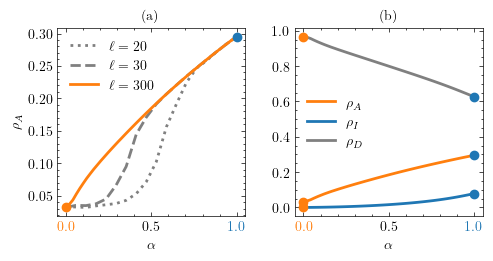

In [113]:
t_trans = 200
base_path = "data/spore-life/time-series"
alphas = np.loadtxt(os.path.join(base_path, "grid-size-300/alpha-range.dat"))
density_300 = np.array([np.mean(np.loadtxt(os.path.join(base_path, "grid-size-300/alive", "alpha-%.3f.dat"%alpha))[:, t_trans:])/(300**2) for alpha in alphas])
density_100 = np.array([np.mean(np.loadtxt(os.path.join(base_path, "grid-size-100/alive", "alpha-%.3f.dat"%alpha))[:, t_trans:])/(100**2) for alpha in alphas])
density_30 = np.array([np.mean(np.loadtxt(os.path.join(base_path, "grid-size-30/alive", "alpha-%.3f.dat"%alpha))[:, t_trans:])/(30**2) for alpha in alphas])
density_20 = np.array([np.mean(np.loadtxt(os.path.join(base_path, "grid-size-20/alive", "alpha-%.3f.dat"%alpha))[:, t_trans:])/(20**2) for alpha in alphas])

spore_density_300 = np.array([np.mean(np.loadtxt(os.path.join(base_path, f"grid-size-300/spore", "alpha-%.3f.dat"%alpha))[:, t_trans:])/(300**2) for alpha in alphas])
dead_density_300 = 1 - density_300 - spore_density_300

# Plot splines to smooth out data
from scipy.interpolate import make_interp_spline, BSpline
spline_alphas = np.linspace(0, 1, 18)
density_20_smoothed = (make_interp_spline(alphas, density_20, k=3))(spline_alphas)
density_30_smoothed = (make_interp_spline(alphas, density_30, k=3))(spline_alphas)

fig, (axl, axr) = plt.subplots(figsize=(5, 2.5), ncols=2)
axl.set(xlabel=r"$\alpha$", ylabel=r"$\rho_{A}$", box_aspect=1, title="(a)")
axl.set_xticks([0.0, 0.5, 1.0])
xtick_labels = axl.get_xticklabels()
xtick_labels[0].set_color("tab:orange")
xtick_labels[2].set_color("tab:blue")
# axl.plot(alphas, density_20, label=r"$\ell = 20$", linestyle="-.", c="gray")
# axl.plot(alphas, density_30, label=r"$\ell = 20$", linestyle="-.", c="gray")
axl.plot(spline_alphas, density_20_smoothed, label=r"$\ell = 20$", linestyle=":", c="gray")
axl.plot(spline_alphas, density_30_smoothed, label=r"$\ell = 30$", linestyle="--", c="gray")
# axl.plot(alphas, density_100, label=r"$N=100$", linestyle="-", c="gray")
axl.plot(alphas, density_300, label=r"$\ell=300$", linestyle="-", c="tab:orange")
# axl.annotate("GoL", (0, density_300[0]), xytext=(.02, .13),
#                 arrowprops={"arrowstyle":"-|>", "relpos":(0.3, 0.1),
#                             "color":"tab:orange", "shrinkB":5},
#                 bbox={"ec": "tab:orange", "fc": "white"},
#                 c="tab:orange", # backgroundcolor="w", bbox={"ec": "tab:blue", "fc": "white"}
#             ) # edge color and face color
axl.scatter(x=0, y=density_300[0], c="tab:orange", zorder=10)
# axl.annotate("SL", (1, density_300[-1]), xytext=(.8, .18),
#             arrowprops={"arrowstyle":"-|>", "relpos":(0.65, 0.5),
#                         "color":"tab:blue", "shrinkB":5},
#             bbox={"ec": "tab:blue", "fc": "white"},
#             c="tab:blue")
axl.scatter(x=1, y=density_300[-1], c="tab:blue", zorder=10)
axl.legend()

axr.set(xlabel=r"$\alpha$", box_aspect=1, title="(b)")
axr.set_xticks([0.0, 0.5, 1.0])
xtick_labels = axr.get_xticklabels()
xtick_labels[0].set_color("tab:orange")
xtick_labels[2].set_color("tab:blue")
axr.plot(alphas, density_300, c="tab:orange", label=r"$\rho_{A}$")
axr.plot(alphas, spore_density_300, c="tab:blue", label=r"$\rho_{I}$")
axr.plot(alphas, dead_density_300, c="gray", label=r"$\rho_{D}$")
axr.scatter(x=0, y=density_300[0], zorder=10, c="tab:orange")
axr.scatter(x=1, y=density_300[-1], c="tab:blue", zorder=10)
axr.scatter(x=0, y=spore_density_300[0], c="tab:orange", zorder=10)
axr.scatter(x=1, y=spore_density_300[-1], c="tab:blue", zorder=10)
axr.scatter(x=0, y=dead_density_300[0], c="tab:orange", zorder=10)
axr.scatter(x=1, y=dead_density_300[-1], c="tab:blue", zorder=10)
axr.legend()

fig.savefig("img/finite-size-effects.pdf")
fig.savefig("img/finite-size-effects.svg", format="svg")

# Birth Rate and Death Rate

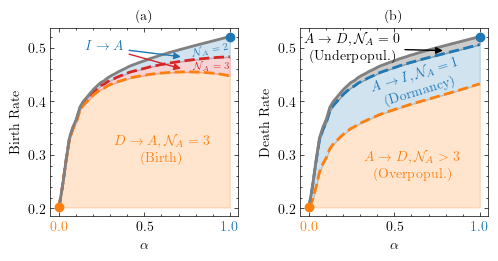

In [144]:
t_max = 10_000; t_trans = 200; runs = 30

base_path = "data/spore-life/state-transitions/transition-table/grid-size-300/"
alphas = np.loadtxt(os.path.join(base_path, "alpha-range.dat"))

# DATA
# birth rate (br)
_mask_2an = np.bool_([[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0]])
_mask_3an_spore = np.bool_([[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0]])
_mask_3an_dead = np.bool_([[0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]])
transitions_2an = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask_2an]) for alpha in alphas])/((t_max-t_trans)*runs)
transitions_3an_spore = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask_3an_spore]) for alpha in alphas])/((t_max-t_trans)*runs)
transitions_3an_dead = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask_3an_dead]) for alpha in alphas])/((t_max-t_trans)*runs)
birth_rate_2an = transitions_2an / (density_300*(300**2))
birth_rate_3an_spore = transitions_3an_spore / (density_300*(300**2))
birth_rate_3an_dead = transitions_3an_dead / (density_300*(300**2))
birth_rate = birth_rate_2an + birth_rate_3an_spore + birth_rate_3an_dead

br_baseline = birth_rate[0]
br_2an_area_percent = (birth_rate-br_baseline)*birth_rate_2an/birth_rate
br_3an_spore_area_percent = (birth_rate-br_baseline)*birth_rate_3an_spore/birth_rate
br_3an_dead_area_percent = (birth_rate-br_baseline)*birth_rate_3an_dead/birth_rate

# death rate (dr)
_mask_spore = np.bool_([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0]])
_mask_lonely = np.bool_([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [1, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0, 0, 0, 0, 0]])
_mask_overcrowd = np.bool_([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 1, 1, 1, 1, 1],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0]])
# transitions_to_dead = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask]) for alpha in alphas])/((t_max-t_trans)*runs)
transitions_spore = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask_spore]) for alpha in alphas])/((t_max-t_trans)*runs)
transitions_lonely = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask_lonely]) for alpha in alphas])/((t_max-t_trans)*runs)
transitions_overcrowd = np.array([np.sum(np.loadtxt(os.path.join(base_path, "alpha-%.3f.dat"%alpha))[_mask_overcrowd]) for alpha in alphas])/((t_max-t_trans)*runs)
death_rate_spore = transitions_spore / (density_300*(300**2))
death_rate_lonely = transitions_lonely / (density_300*(300**2))
death_rate_overcrowd = transitions_overcrowd / (density_300*(300**2))
death_rate = death_rate_spore + death_rate_lonely + death_rate_overcrowd

dr_baseline = death_rate[0]
overcrowd_area_percent = (death_rate-dr_baseline)*death_rate_overcrowd/death_rate
spore_area_percent =  (death_rate-dr_baseline)*death_rate_spore/death_rate
lonely_area_percent = (death_rate-dr_baseline)*death_rate_lonely/death_rate

# PLOT
fig, (axl, axr) = plt.subplots(figsize=(5, 2.5), ncols=2)
axl.set(xlabel=r"$\alpha$", ylabel=r"Birth Rate", box_aspect=1)
axl.set_xticks([0.0, 0.5, 1.0])
xtick_labels = axl.get_xticklabels()
xtick_labels[0].set_color("tab:orange")
xtick_labels[2].set_color("tab:blue")
axl.set_title("(a)", loc="center")

axl.plot(alphas, br_baseline+br_3an_dead_area_percent+br_3an_spore_area_percent, linestyle="--", c="tab:red")
axl.plot(alphas, br_baseline+br_3an_dead_area_percent, linestyle="--", c="tab:orange")
axl.plot(alphas, birth_rate, c="gray")

axl.fill_between(alphas, [br_baseline]*len(alphas), br_baseline+br_3an_dead_area_percent, alpha=0.2, zorder=-1, color="tab:orange")
axl.fill_between(alphas, br_baseline+br_3an_dead_area_percent, br_baseline+br_3an_dead_area_percent+br_3an_spore_area_percent, alpha=0.2, zorder=-1, color="tab:red")
axl.fill_between(alphas, br_baseline+br_3an_dead_area_percent+br_3an_spore_area_percent, birth_rate, alpha=0.2, zorder=-1, color="tab:blue")
# axl.annotate("Game of Life", (0, birth_rate[0]), xytext=(.15, .25),
#             arrowprops={"arrowstyle":"->", "relpos":(0.5, 0.5),
#                         "color":"tab:blue", "shrinkB":10},
#             c="tab:blue") # edge color and face color
axl.scatter(x=0, y=birth_rate[0], c="tab:orange", zorder=10)
# axl.annotate("Dormant Life", (1, birth_rate[-1]), xytext=(.55, .4),
#             arrowprops={"arrowstyle":"->", "relpos":(0.65, 0.5),
#                         "color":"tab:orange", "shrinkB":5},
#             c="tab:orange")
axl.scatter(x=1, y=birth_rate[-1], c="tab:blue", zorder=10)
axl.text(0.32, 0.32, r"\begin{center}${D}\to{A}, \mathcal{N}_A=3$ \\ (Birth)\end{center}", c="tab:orange")
axl.text(0.77, 0.485, r"$\mathcal{N}_A=2$", c="tab:blue", fontsize=7, rotation=10)
axl.text(0.78, 0.461, r"$\mathcal{N}_A=3$", c="tab:red", fontsize=7, rotation=0)
axl.annotate(r"${I}\to{A}$", (0.73, 0.460), xytext=(0.15, 0.495),
            arrowprops={"arrowstyle":"-|>", "relpos":(.5,.5),
                        "color":"tab:red"},
            c="tab:blue", zorder=20)
axl.annotate(r"${I}\to{A}$", (0.73, 0.483), xytext=(0.15, 0.495), alpha=0,
            arrowprops={"arrowstyle":"-|>", "relpos":(.5,.5),
                        "color":"tab:blue"},
            c="tab:red", zorder=20)

axr.set(xlabel=r"$\alpha$", ylabel=r"Death Rate", title="(b)", box_aspect=1)
axr.set_xticks([0.0, 0.5, 1.0])
xtick_labels = axr.get_xticklabels()
xtick_labels[0].set_color("tab:orange")
xtick_labels[2].set_color("tab:blue")
axr.plot(alphas, dr_baseline+overcrowd_area_percent+spore_area_percent, c="tab:blue", ls="--")
axr.plot(alphas, dr_baseline+overcrowd_area_percent, c="tab:orange", ls="--")
axr.plot(alphas, death_rate, c="gray")
axr.fill_between(alphas, [dr_baseline]*len(alphas),
                dr_baseline+overcrowd_area_percent,
                alpha=0.2, zorder=-1, color="tab:orange")
axr.fill_between(alphas, dr_baseline+overcrowd_area_percent, 
                dr_baseline+overcrowd_area_percent+spore_area_percent,
                alpha=0.2, zorder=-1, color="tab:blue")
axr.fill_between(alphas, dr_baseline+overcrowd_area_percent+spore_area_percent, 
                death_rate,
                alpha=0.2, zorder=-1, color="black")
axr.scatter(x=0, y=death_rate[0], c="tab:orange", zorder=10)
axr.scatter(x=1, y=death_rate[-1], c="tab:blue", zorder=10)
axr.text(0.32, 0.29, r"\begin{center}${A}\to{D}, \mathcal{N}_A>3$ \\ (Overpopul.)\end{center}", c="tab:orange")
axr.text(0.35, 0.42, r"\begin{center}${A}\to{I}, \mathcal{N}_A=1$ \\ (Dormancy)\end{center}", c="tab:blue", rotation=17)
axr.annotate(r"\begin{center}${A} \to {D}, \mathcal{N}_A=0$ \\ (Underpopul.)\end{center}", (0.8, 0.495), xytext=(-0.03, 0.51),
            arrowprops={"arrowstyle":"-|>", "relpos":(.5,.5),
                        "color":"black", },
            c="black", zorder=20)

fig.savefig("img/birth-death-rate.pdf")
fig.savefig("img/birth-death-rate.svg", format="svg")